# DTSA 5511 Final Project
Title: Deep Learning for SMS Spam Detection  
Author: Ali Saleh    

# 1. Problem Identification and Data Acquisition:

### 1.1. Introduction & Deep Learning Problem Identification

**Problem Statement:**
SMS spam, also known as unsolicited commercial text messages, is a persistent issue for mobile users worldwide. These messages range from mere annoyances to serious threats involving financial scams, phishing attempts, and malware distribution. The sheer volume and evolving nature of spam make manual filtering impractical.

**Project Goal:**
The primary goal of this project is to develop, train, and evaluate deep learning models capable of accurately classifying SMS messages as either spam or not.

**Deep Learning Aspect:**

This project leverages **deep learning techniques**, specifically **Natural Language Processing (NLP) transfer learning**, for SMS spam detection. Given the success of large pre-trained language models like BERT and its variants on a wide range of NLP tasks, using a pre-trained model and fine-tuning it on our specific dataset is a highly effective approach.

**Why Transfer Learning?**

1.  **Leveraging Pre-trained Knowledge:** Models like DistilBERT have been trained on massive text corpora (like the entire English Wikipedia and BookCorpus). This pre-training allows them to learn rich, general-purpose representations of language, including syntax, semantics, and context.
2.  **Reduced Data Requirements:** Training a deep learning model from scratch for a task like text classification typically requires a very large labeled dataset. Transfer learning allows us to achieve high performance with a relatively smaller task-specific dataset (our SMS spam collection) by building upon the knowledge already encoded in the pre-trained model.
3.  **Faster Training:** Fine-tuning a pre-trained model is significantly faster than training a large model from scratch, as the initial layers already have learned weights.
4.  **State-of-the-Art Performance:** Transformer-based models have demonstrated state-of-the-art performance on numerous text classification benchmarks, making them a strong choice for this task.

By employing NLP transfer learning with a model like DistilBERT, we aim to build a robust and accurate spam detection system that effectively captures the nuances of language in SMS messages.


### 1.2. Data Set descreption and source:

**Data Source:**
The dataset used in this project is the **SMS Spam Collection Dataset** from the UCI Machine Learning Repository.

**Link:**
[https://archive.ics.uci.edu/ml/datasets/sms+spam+collection](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

**Description:**
This dataset consists of 5,572 SMS messages in English. Each message is tagged as either "ham" (legitimate) or "spam". It is a widely used benchmark dataset for text classification tasks.

**Method of Collection:**
The data was downloaded directly from the UCI Machine Learning Repository.

# 2. Importing Libraries and dataset:

### 2.1. Importing Libraries and necessary resources:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


import tensorflow as tf
import tf_keras as tf_
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences
from tf_keras.models import Sequential
from tf_keras.layers import Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, GlobalMaxPooling1D
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint
from tf_keras.mixed_precision import set_global_policy
from transformers import BertTokenizer, TFBertForSequenceClassification
from tf_keras.optimizers.schedules import PolynomialDecay

# Set some global styles for plots
plt.style.use('ggplot')
sns.set_palette("viridis")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Enable mixed precision training for faster computation
set_global_policy('mixed_float16')

In [ ]:
# Downloading necessary NLTK resources

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2.2. Importing data and having an initial inspection:

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/final project deep/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])
print(df.head())
print(df.info())
print(df['label'].value_counts())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


# 3. Exploratory Data Analysis (EDA)


### 3.1. Checking for missing values:

In [ ]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
label      0
message    0
dtype: int64


**Observation:** No missing data

### 3.2. Checking Label Distribution:

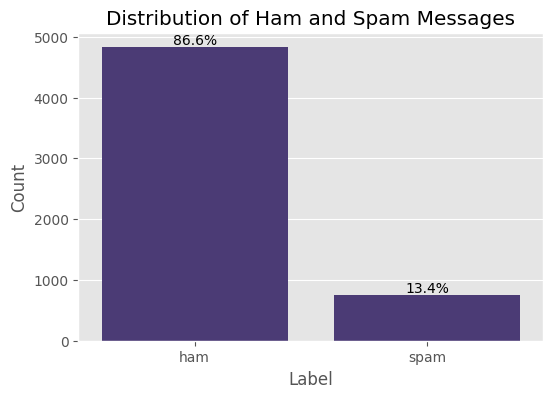

In [ ]:
# Distribution of labels
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=df)
plt.title('Distribution of Ham and Spam Messages')
plt.xlabel('Label')
plt.ylabel('Count')

# Add percentages on top of bars
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

**Observations:** The dataset is imbalanced, with significantly more "ham" messages than "spam" messages (approximately 86.6% ham vs. 13.4% spam).  
**Actions:**  
1. Evaluation Metrics:  as metrics like accuracy can be misleading. Precision, recall, and F1-score for the minority class (spam) will be more informative.  
2. Data Splitting: We will use stratified splitting later to ensure this distribution is maintained in train/test sets.

### 3.3. Checking Distribution of Message lengths by label:

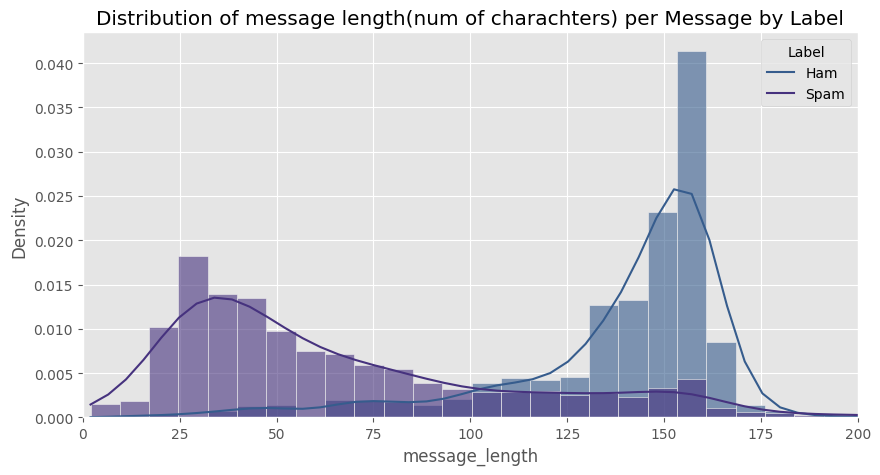

In [ ]:
# message_length column
df['message_length'] = df['message'].apply(len)
# Plot the distribution of message_length for each label
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='message_length', hue='label', bins=120, kde=True, stat='density', common_norm=False, alpha=0.6)
plt.title('Distribution of message length(num of charachters) per Message by Label')
plt.xlabel('message_length')
plt.ylabel('Density')
plt.xlim(0, 200)  # Limit x-axis for better visibility
plt.legend(title='Label', labels=['Ham', 'Spam'])  # Explicitly define labels
plt.show()

**Observation:** Spam messages, on average, tend to be longer than ham messages. The distribution for spam message lengths is also wider. This suggests that message length could be a useful feature for classification.

### 3.4. Creating Word Count column and checking its distribution by labels:

In [ ]:
# Adding a column for word count in each message
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

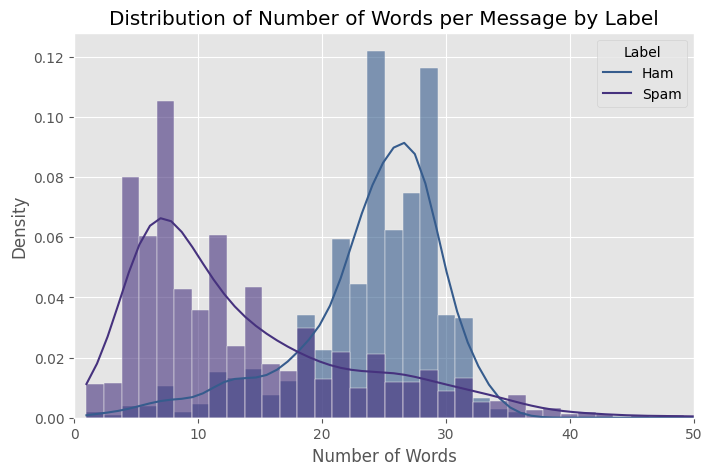

In [ ]:
# Plot the distribution of word counts for each label
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='word_count', hue='label', bins=120, kde=True, stat='density', common_norm=False, alpha=0.6)
plt.title('Distribution of Number of Words per Message by Label')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.xlim(0, 50)  # Limit x-axis for better visibility
plt.legend(title='Label', labels=['Ham', 'Spam'])  # Explicitly define labels
plt.show()

**Observation:** Similar to message length, spam messages also tend to have a higher word count on average compared to ham messages.

### 3.5. Examining Comon words for each class:

In [ ]:
stop_words_nltk = set(stopwords.words('english'))

# Add some common but uninformative words if needed (e.g., from SMS context)
custom_stopwords = {'u', 'ur', 'r', 'ü', '2', '4', 'im', 'ü', 'ok', 'lt', 'gt'}
stop_words_combined = stop_words_nltk.union(custom_stopwords)


def basic_clean_for_wordcloud(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text)    # Remove numbers for cleaner word clouds
    words = text.split()
    words = [word for word in words if word not in stop_words_combined and len(word) > 1]
    return " ".join(words)

# Apply basic cleaning for word cloud generation
df_spam_text = " ".join(df[df['label']=='spam']['message'].apply(basic_clean_for_wordcloud))
df_ham_text = " ".join(df[df['label']=='ham']['message'].apply(basic_clean_for_wordcloud))

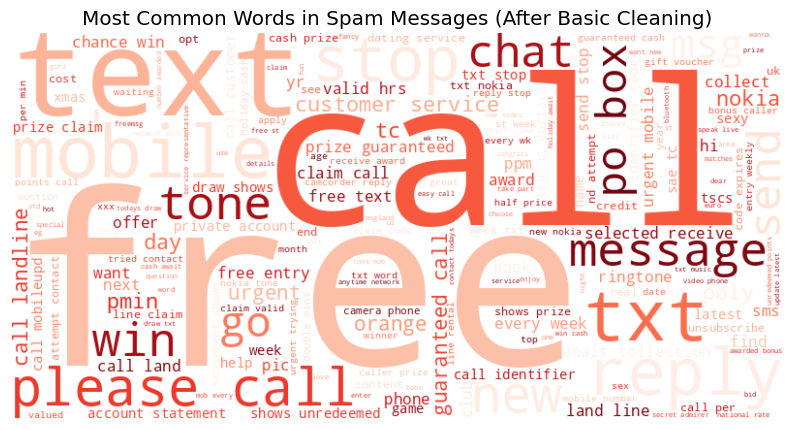

In [ ]:
# Word Cloud for Spam Messages
wordcloud_spam = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(df_spam_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Spam Messages (After Basic Cleaning)')
plt.show()

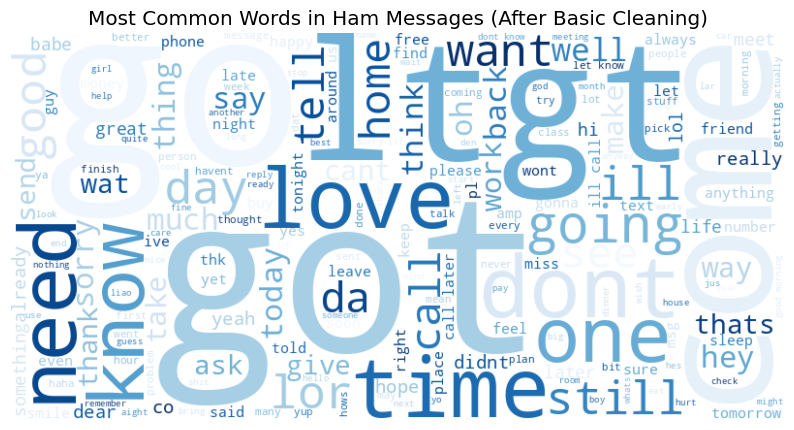

In [ ]:
# Word Cloud for Ham Messages
wordcloud_ham = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(df_ham_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Ham Messages (After Basic Cleaning)')
plt.show()

**Observation:**
  
*   **Spam messages** often contain words like "free" "call" "txt" "claim" "prize" which are typical of unsolicited offers, competitions, or subscriptions.  
     

*   **Ham messages** show more conversational words like "get" "go" "know" "love" "good" "time" "day"  
       
These distinct vocabularies highlight the potential for content-based classification.

# 4. Data Cleaning and preprocessing:

### 4.1. Cleaning Data ??

**BERT tokenizers are pretrained on raw, untampered text:**  
1. They expect punctuation, capitalization, and even URLs/emails/numbers.

2. Replacing them or stripping punctuation disrupts the learned patterns.

**BERT already uses WordPiece tokenization:**
1. It handles unknown words (e.g., “fr33dom”) better than classical tokenizers.

2. Special characters, digits, casing patterns can help the model differentiate spam from ham. [2]

### 4.2. label encoding:

In [ ]:
encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])

# Verify mapping (e.g., ham:0, spam:1)
print("Label mapping:")
for i, class_name in enumerate(encoder.classes_):
    print(f"{class_name}: {encoder.transform([class_name])[0]}")

df.head()

Label mapping:
ham: 0
spam: 1


,label,message,message_length,word_count,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,0
1,ham,Ok lar... Joking wif u oni...,29,6,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,1
3,ham,U dun say so early hor... U c already then say...,49,11,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0


### 4.3. Data splitting:

In [ ]:
X = df['message']  # Features (raw text messages)
y = df['label_encoded'] # Target (numerical labels)

# Split into training_full (for train/val) and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.20,       # 20% for the final unseen test set
    random_state=42,      # For reproducibility
    stratify=y            # Preserve class proportions due to imbalance
)

# Further split training_full into actual training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.10,       # e.g., 10% of the (80% training_full data) for validation
    random_state=42,
    stratify=y_train_full # Stratify on the training_full labels
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Convert Pandas Series to lists of strings, which tokenizers often prefer
X_train_list = X_train.tolist()
X_val_list = X_val.tolist()
X_test_list = X_test.tolist()

Training samples: 4011
Validation samples: 446
Test samples: 1115


### 4.4. Tokenization:

**Initializing and configuiring bert tokenizer:**

In [ ]:
MODEL_NAME = 'distilbert-base-uncased' # Smaller, faster BERT variant.
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer for '{MODEL_NAME}' loaded successfully.")
MAX_LENGTH = 128  # Maximum sequence length for BERT input (common for SMS)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Tokenizer for 'distilbert-base-uncased' loaded successfully.


**Defining tokenizer function:**

In [ ]:
def bert_encode_texts(texts, tokenizer_obj, max_len=MAX_LENGTH):
    """Tokenizes a list of texts and prepares them for BERT input."""
    input_ids_list = []
    attention_masks_list = []

    for text_item in texts:
        encoded_dict = tokenizer_obj.encode_plus(
            text_item,
            add_special_tokens=True,    # Add '[CLS]' and '[SEP]'
            max_length=max_len,         # Pad & truncate all sentences.
            padding='max_length',       # Pad to max_length
            truncation=True,
            return_attention_mask=True, # Construct attention masks.
            return_tensors='tf',        # Return TensorFlow tensors.
        )
        input_ids_list.append(tf.convert_to_tensor(encoded_dict['input_ids']))
        attention_masks_list.append(tf.convert_to_tensor(encoded_dict['attention_mask']))

    # Concatenate the lists of tensors into single tensors
    input_ids = tf.concat(input_ids_list, axis=0)
    attention_masks = tf.concat(attention_masks_list, axis=0)

    return input_ids, attention_masks

**Tokenizing datasets:**

In [ ]:
# Tokenize all datasets
train_input_ids, train_attention_masks = bert_encode_texts(X_train_list, tokenizer, MAX_LENGTH)
val_input_ids, val_attention_masks = bert_encode_texts(X_val_list, tokenizer, MAX_LENGTH)
test_input_ids, test_attention_masks = bert_encode_texts(X_test_list, tokenizer, MAX_LENGTH)

print("Text data tokenized for BERT.")
print(f"Shape of train_input_ids: {train_input_ids.shape}")

Text data tokenized for BERT.
Shape of train_input_ids: (4011, 128)


### 4.5. Converting the tokenized data and labels to a tensor dataset object for better optimization during training:

**Convert labels to TensorFlow tensors**

In [ ]:
y_train_tf = tf.convert_to_tensor(y_train.values.squeeze(), dtype=tf.int32)
y_val_tf = tf.convert_to_tensor(y_val.values.squeeze(), dtype=tf.int32)
y_test_tf = tf.convert_to_tensor(y_test.values.squeeze(), dtype=tf.int32)

defining func: **create_tf_dataset_for_bert**

In [ ]:
def create_tf_dataset_for_bert(input_ids, attention_masks, labels, batch_size, shuffle=True):
    """Creates a tf.data.Dataset for BERT training/evaluation."""
    dataset = tf.data.Dataset.from_tensor_slices(
        ({'input_ids': input_ids, 'attention_mask': attention_masks}, labels)
    )
    if shuffle:
        dataset = dataset.shuffle(len(labels)) # Shuffle buffer size = dataset size
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) # Optimize performance
    return dataset

**Creating datasets**

In [ ]:
BATCH_SIZE = 32 # Adjust based on your GPU memory. 16 or 32 are common.

train_dataset_bert = create_tf_dataset_for_bert(train_input_ids, train_attention_masks, y_train_tf, BATCH_SIZE, shuffle=True)
val_dataset_bert = create_tf_dataset_for_bert(val_input_ids, val_attention_masks, y_val_tf, BATCH_SIZE, shuffle=False)
test_dataset_bert = create_tf_dataset_for_bert(test_input_ids, test_attention_masks, y_test_tf, BATCH_SIZE, shuffle=False) # No shuffle for test

print("TensorFlow datasets for BERT created.")

TensorFlow datasets for BERT created.


# 5. Pretrained Model and finetuning:

## 5.1. Loading Pre-trained BERT Model for Sequence Classification:

**Chosen Model:** distilbert-base-uncased  
  
Model was chosen as it is a smaller more effecient version of bert that's:  
1. 40% smaller than bert-base-uncased.  
2. 60% faster to train.  
3. still retains ~95% of performance


In [ ]:
bert_classification_model = TFBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1
)
print(f"Pre-trained BERT model '{MODEL_NAME}' with a classification head loaded.")

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.transformer.layer.1.attention.q_lin.bias', 'distilbert.transformer.layer.1.attention.q_lin.weight', 'distilbert.transformer.layer.3.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.5.ffn.lin1.weight', 'distilbert.transformer.layer.4.output_layer_norm.weight', 'distilbert.transformer.layer.4.ffn.lin2.bias', 'distilbert.transformer.layer.5.ffn.lin2.weight', 'distilbert.transformer.layer.1.attention.v_lin.weight', 'distilbert.transformer.layer.1.attention.k_lin.weight', 'distilbert.transformer.layer.2.output_layer_norm.bias', 'distilbert.transformer.layer.4.ffn.lin2.weight', 'vocab_layer_norm.bias', 'distilbert.transformer.layer.1.attention.k_lin.bias', 'distilber

Pre-trained BERT model 'distilbert-base-uncased' with a classification head loaded.


## 5.2. Preparing model for finetuning:

### 5.2.2. Setting Learning rate, optimizer and loss function:

**Optimizer:** AdamW is recommended for Transformers.  
**Learning Rate:** A small learning rate is selected for finetuning.  
**Loss Function:** since TFBertForSequenceClassification outputs logits we will use BinaryCrossentropy.

In [ ]:
LEARNING_RATE = 2e-5
optimizer_bert = tf.optimizers.AdamW(learning_rate=LEARNING_RATE, epsilon=1e-08)
loss_bert = tf.losses.BinaryCrossentropy (from_logits=True)

### 5.2.3. Compiling Model and Model summary:

In [ ]:
# Compile the BERT model with the optimizer, loss function, and metrics

print("Compiling BERT model...")
bert_classification_model.compile(
    optimizer=optimizer_bert,
    loss=loss_bert,
    metrics='accuracy'
)
print("BERT model compiled.")

# Model Summary:
print("BERT model summary:")
bert_classification_model.summary() # View model structure

Compiling BERT model...
BERT model compiled.
BERT model summary:
Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 5.3. Finetuning Model:

### 5.3.1. setting finetuning hyperparameters:

Finetuning BERT should require us 2-4 epochs of training according to the BERT paper by Devlin et al., 2018 [3]

In [ ]:
NUM_EPOCHS_BERT = 3
BATCH_SIZE = 32

**Setting Learning rate scheduler for more optimized training**

In [ ]:
LEARNING_RATE = PolynomialDecay(initial_learning_rate=2e-5,
                                  decay_steps=1000,
                                  end_learning_rate=1e-6)

**Freezing Lower Layers**  
After doing some research on how many layers to freeze, according to the paper published in 2019 by Jaejun Lee et. al. [4] I decided to freeze the first 6 layers for finetuning.

In [ ]:
for layer in bert_classification_model.bert.encoder.layer[:6]:
    layer.trainable = False
print("Lower layers of BERT model frozen.")

Lower layers of BERT model frozen.


**Finally callbacks for early stopping and saving best model are added**

while early stopping might not be as important here since we are training only for 3 epochs it is still good practice and I decided to add it.

In [ ]:
# early stopping callback to prevent overfitting
early_stopping_bert_cb = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=1,               # Stop if no improvement after 1 epoch
    restore_best_weights=True # Restore weights from the best epoch
)

# ModelCheckpoint to save the best model
checkpoint_filepath = './bert_spam_detector_checkpoint.weights.h5'
model_checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

### 5.3.2. Finetuning Model:

**Adressing Imbalance**

In [ ]:
# Calculate class weights for imbalanced data
total_samples = len(y_train)
num_classes = len(y_train.unique())
class_counts = y_train.value_counts().sort_index()

class_weights = {}
for class_label, count in class_counts.items():
    class_weights[class_label] = total_samples / (num_classes * count)

print("Calculated class weights:")
print(class_weights)

Calculated class weights:
{0: 0.5774546501583645, 1: 3.7276951672862455}


In [ ]:
print(f"Starting fine-tuning of '{MODEL_NAME}' for {NUM_EPOCHS_BERT} epochs with class weights...")
history_bert_finetune_weighted = bert_classification_model.fit(
    train_dataset_bert,
    epochs=NUM_EPOCHS_BERT,
    validation_data=val_dataset_bert,
    callbacks=[early_stopping_bert_cb, model_checkpoint_cb],
    class_weight=class_weights, # Apply class weights here
    verbose=1  # Show progress
)
print("BERT model fine-tuning with class weights complete.")

Starting fine-tuning of 'distilbert-base-uncased' for 3 epochs with class weights...
Epoch 1/3
126/126 [==============================] - 201s 656ms/step - loss: 0.3545 - accuracy: 0.8766 - val_loss: 0.2985 - val_accuracy: 0.8946
Epoch 2/3
126/126 [==============================] - 107s 849ms/step - loss: 0.1116 - accuracy: 0.9763 - val_loss: 0.1606 - val_accuracy: 0.9529
Epoch 3/3
126/126 [==============================] - 99s 785ms/step - loss: 0.0488 - accuracy: 0.9875 - val_loss: 0.0583 - val_accuracy: 0.9798
BERT model fine-tuning with class weights complete.


# 6. Model Evaluation:

### 6.1. Training and validation:

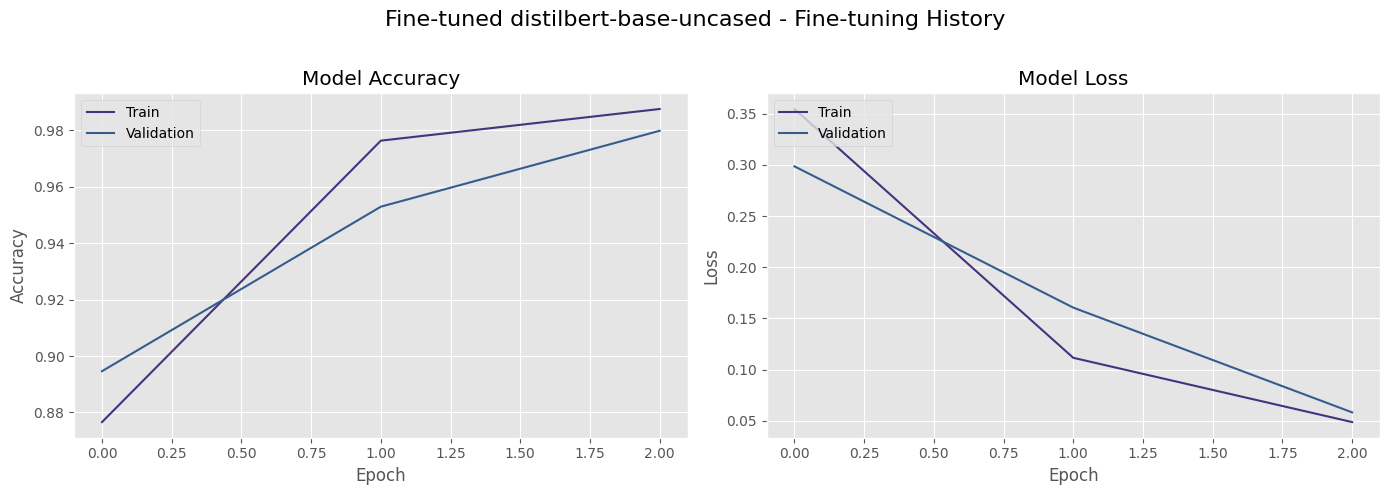

In [ ]:
# Plot training history
def plot_bert_finetuning_history(history, model_name_str):
    """Plots accuracy and loss from BERT fine-tuning history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{model_name_str} - Fine-tuning History', fontsize=16)

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_bert_finetuning_history(history_bert_finetune_weighted, f"Fine-tuned {MODEL_NAME}")

### 6.2. Evaluating Model on Unseen test data:

In [ ]:
# Evaluate on the test dataset
print(f"\nEvaluating fine-tuned '{MODEL_NAME}' on the test set...")
results_bert_eval = bert_classification_model.evaluate(test_dataset_bert, verbose=0)

print(f"Test Loss: {results_bert_eval[0]:.4f}")
print(f"Test Accuracy: {results_bert_eval[1]:.4f}") # Assumes accuracy is the first metric

# Get predictions on the test set to calculate detailed metrics
test_predictions_logits = bert_classification_model.predict(test_dataset_bert, verbose=0)


Evaluating fine-tuned 'distilbert-base-uncased' on the test set...
Test Loss: 0.0505
Test Accuracy: 0.9857



Evaluating fine-tuned 'distilbert-base-uncased' on the test set...
Test Loss: 0.0505
Test Accuracy: 0.9857

Classification Report (Fine-tuned BERT):
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.93      0.95      0.94       149

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.97      1115
weighted avg       0.98      0.98      0.98      1115



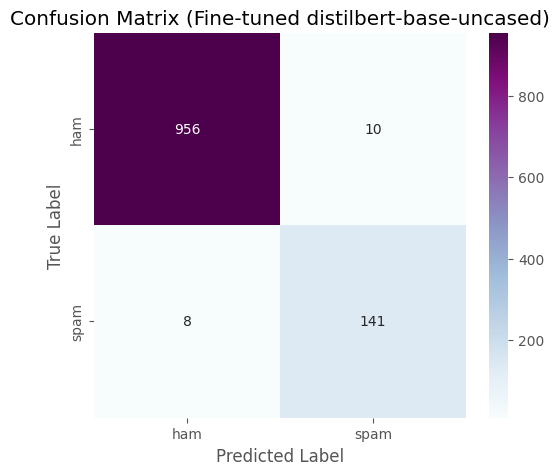

Accuracy: 0.9839
Precision (Spam): 0.9338
Recall (Spam): 0.9463
F1-score (Spam): 0.9400


In [48]:
# Evaluate on the test dataset
print(f"\nEvaluating fine-tuned '{MODEL_NAME}' on the test set...")
results_bert_eval = bert_classification_model.evaluate(test_dataset_bert, verbose=0)

print(f"Test Loss: {results_bert_eval[0]:.4f}")
print(f"Test Accuracy: {results_bert_eval[1]:.4f}") # Assumes accuracy is the first metric

# Get predictions on the test set to calculate detailed metrics
test_predictions_logits = bert_classification_model.predict(test_dataset_bert, verbose=0)
# The output of `predict` for TFBertForSequenceClassification is an object,
# the logits are in `predictions.logits`
# Use sigmoid for binary classification with a single output logit
test_probabilities_bert = tf.nn.sigmoid(test_predictions_logits.logits)
test_predicted_labels_bert = tf.cast(test_probabilities_bert > 0.5, dtype=tf.int32).numpy() # Use a threshold (e.g., 0.5) to get binary predictions

# y_test_tf contains the true labels for the test set as TensorFlow tensor.
# Convert to NumPy array for scikit-learn metrics.
y_test_numpy = y_test_tf.numpy()

print("\nClassification Report (Fine-tuned BERT):")
print(classification_report(y_test_numpy, test_predicted_labels_bert, target_names=encoder.classes_))

# Confusion Matrix
cm_bert_finetuned = confusion_matrix(y_test_numpy, test_predicted_labels_bert)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bert_finetuned, annot=True, fmt="d", cmap="BuPu",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title(f"Confusion Matrix (Fine-tuned {MODEL_NAME})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Extract metrics for 'ham' and 'spam' classes (assuming 'ham' is 0 and 'spam' is 1 based on LabelEncoder)
report = classification_report(y_test_numpy, test_predicted_labels_bert, target_names=encoder.classes_, output_dict=True)

spam_metrics = report['spam']
accuracy = report['accuracy'] # Accuracy is a separate entry

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Spam): {spam_metrics['precision']:.4f}")
print(f"Recall (Spam): {spam_metrics['recall']:.4f}")
print(f"F1-score (Spam): {spam_metrics['f1-score']:.4f}")

# 7. Conclusion:

Based on the evaluation of the fine-tuned DistilBERT model for SMS spam detection, we can draw the following conclusions:

**Conclusion:**

The fine-tuned DistilBERT model achieved excellent performance on the unseen test dataset, with a high overall accuracy of 98.39%. More importantly, considering the class imbalance, the model demonstrated strong performance on the minority "spam" class:

*   **Precision (Spam):** 0.9338 - This means that when the model predicts a message is spam, it is correct about 93.4% of the time, minimizing false positives.
*   **Recall (Spam):** 0.9463 - This indicates that the model successfully identifies about 94.6% of all actual spam messages, minimizing false negatives.
*   **F1-score (Spam):** 0.9400 - This is a harmonic mean of precision and recall, providing a balanced measure of the model's effectiveness on the spam class.

The confusion matrix visually confirms these results, showing a low number of misclassifications for both ham and spam. The class weighting during training likely contributed to the strong performance on the spam class despite the dataset's imbalance.

Overall, the fine-tuned DistilBERT model is highly effective for this SMS spam detection task, demonstrating the power of transfer learning for NLP.

**Future Improvements:**

While the current model performs well, here are some potential areas for future exploration and improvement:

1.  **Explore Other Pre-trained Models:** Experiment with other state-of-the-art Transformer models (e.g., RoBERTa, ELECTRA, or even larger BERT variants if computational resources allow) to see if further performance gains can be achieved.
2.  **Hyperparameter Tuning:** Conduct more extensive hyperparameter tuning for the finetuning process, including learning rate schedules, batch size, optimizer parameters, and the number of unfrozen layers.
3.  **Data Augmentation:** Implement data augmentation techniques specific to text data (e.g., synonym replacement, random insertion, deletion, or swapping of words) to potentially increase the size and diversity of the training data, especially for the minority class.
4.  **Ensemble Methods:** Combine predictions from multiple models (e.g., different Transformer architectures or traditional ML models) to potentially improve robustness and performance.

# 8. References:

1. Almeida, T. & Hidalgo, J. (2011). SMS Spam Collection [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5CC84.

2. user702846. (2022, August 9). Why there is no preprocessing step for training BERT? Data Science Stack Exchange. Retrieved June 23, 2025, from https://datascience.stackexchange.com/questions/113359/why-there-is-no-preprocessing-step-for-training-bert

3. Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre‑training of deep bidirectional transformers for language understanding. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies (NAACL‑HLT), Volume 1 (Long and Short Papers) (pp. 4171–4186). Association for Computational Linguistics.

4. Lee, J., Tang, R., & Lin, J. (2019, November 8). What Would Elsa Do? Freezing Layers During Transformer Fine‑Tuning [Preprint]. arXiv. https://doi.org/10.48550/arXiv.1911.03090

# 9. Github Repo:



https://github.com/alimonds790/NLP_transfer_learning-SMS-spam-Classification
